# Spatial Cross validation
Affichage des labels sur la carte du Vietnam, Séparation du jeu d’entrainement, validation et test avec une séparation spatiale

* Romain Capocasale
* IADeforestation
* HES-SO MASTER

# Import

In [1]:
import pandas as pd
import os
import rasterio
import geopandas as gpd
import spacv
import matplotlib.pyplot as plt
import numpy as np
import random

from shapely import wkt
from shapely.geometry.point import Point

from IAdeforestation.preprocessing import *
from IAdeforestation.spatial_cross_val import *

/home/romain.capocasa/romain_env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
vietnam = gpd.read_file("district/diaphanhuyen.shp")

# Shapefile import

In [4]:
LABELS_PATH = 'labels'
SHAPEFILES_PATHS = [os.path.join(LABELS_PATH, 'central_highlands_1_other', 'central_highlands_1_other.shp'),
 os.path.join(LABELS_PATH, 'central_highlands_2_test', 'central_highlands_2_test.shp'),
 os.path.join(LABELS_PATH, 'central_highlands_2_other', 'central_highlands_2_other.shp')]

SHAPEFILE_ESPG=4326

points = process_shapefile(SHAPEFILES_PATHS)

In [5]:
coords, labels = zip(*points)

In [6]:
coords_points = []
plt.show
for p in coords:
    coords_points.append(Point(p[0],p[1]))

In [7]:
geo_df = gpd.GeoDataFrame({'geometry':coords_points, 'labels':labels})

In [8]:
geo_df

,geometry,labels
0,POINT (107.94103 14.43993),6
1,POINT (107.93873 14.44076),6
2,POINT (107.94177 14.43879),6
3,POINT (107.94323 14.43819),6
4,POINT (107.94079 14.43759),6
...,...,...
10264,POINT (107.89111 11.55182),17
10265,POINT (107.89070 11.55158),17
10266,POINT (107.89042 11.55184),17
10267,POINT (107.89034 11.55139),17


# Shapefile on Vietnam map
The purpose here is simply to visualize the labels provided by CIAT on the map of Vietnam.

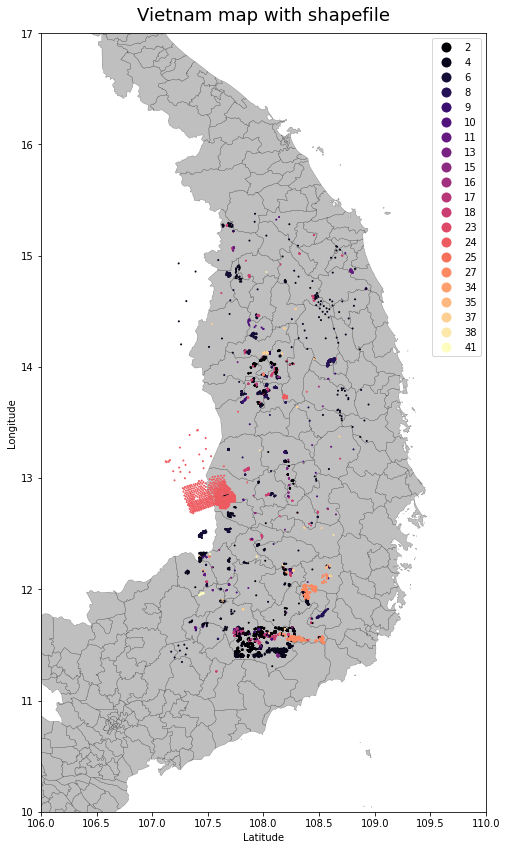

In [9]:
fig, ax = plt.subplots(figsize=(12,12))

vietnam.plot(ax=ax,facecolor='Grey', edgecolor='k',alpha=0.5,linewidth=0.3)
geo_df.plot(ax=ax, markersize=1,categorical=True, legend=True, column="labels", cmap="magma")
ax.set_ylim([10,17])
ax.set_xlim([106,110])
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")
fig.suptitle("Vietnam map with shapefile", fontsize=18)
fig.tight_layout()

# Dataset Split - Classic version
The purpose here is to present the repair of folds with the traditional separation method (label not taken into account). 
## Split train / test
### Load original data

In [24]:
all_data = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'strat_all.csv')))
all_data['geometry'] = all_data['geometry'].apply(wkt.loads)

### Compute 5 spatial folds

In [25]:
skcv = spacv.SKCV(n_splits=5, buffer_radius=0.1).split(all_data['geometry'])

labels = {}
fold_i = 0

for train, validation in skcv:
    geo_train = all_data.iloc[train]
    geo_val = all_data.iloc[validation]
        
    tr_0 = len(geo_train[geo_train['label']==2])
    tr_1 = len(geo_train[geo_train['label']!=2])
    
    va_0 = len(geo_val[geo_val['label']==2])
    va_1 = len(geo_val[geo_val['label']!=2])
    
    print(f"train 0 : {tr_0/(tr_0+tr_1)}")
    print(f"train 1 : {tr_1/(tr_0+tr_1)}")
    
    print(f"test 0 : {va_0/(va_0+va_1)}")
    print(f"test 1 : {va_1/(va_0+va_1)}")
    print("----------")
    
    labels[fold_i] = [train, validation]
    
    fold_i+=1

train 0 : 0.24805800103573278
train 1 : 0.7519419989642672
test 0 : 0.14615384615384616
test 1 : 0.8538461538461538
----------
train 0 : 0.1176
train 1 : 0.8824
test 0 : 0.43859649122807015
test 1 : 0.5614035087719298
----------
train 0 : 0.25745784695201035
train 1 : 0.7425421530479897
test 0 : 0.19460500963391136
test 1 : 0.8053949903660886
----------
train 0 : 0.26914660831509846
train 1 : 0.7308533916849015
test 0 : 0.021645021645021644
test 1 : 0.9783549783549783
----------
train 0 : 0.27602905569007263
train 1 : 0.7239709443099274
test 0 : 0.06005221932114883
test 1 : 0.9399477806788512
----------


### Select the folds for train and test
Here one fold is used as a training set and the remaining 4 as a test set.

In [29]:
data_train = all_data.iloc[labels[1][0]]
data_test = all_data.iloc[labels[1][1]]

### Split train / validation
The algorithm is restarted the training set only to create the folds.

Fold 1 Number coffee - train : 125
Fold 1 Number no-coffee - train : 744
Fold 1 Number coffee - val : 22
Fold 1 Number no-coffee - val : 359
-----
Fold 2 Number coffee - train : 47
Fold 2 Number no-coffee - train : 774
Fold 2 Number coffee - val : 100
Fold 2 Number no-coffee - val : 327
-----
Fold 3 Number coffee - train : 142
Fold 3 Number no-coffee - train : 888
Fold 3 Number coffee - val : 5
Fold 3 Number no-coffee - val : 215
-----
Fold 4 Number coffee - train : 128
Fold 4 Number no-coffee - train : 992
Fold 4 Number coffee - val : 19
Fold 4 Number no-coffee - val : 111
-----
Fold 5 Number coffee - train : 143
Fold 5 Number no-coffee - train : 1010
Fold 5 Number coffee - val : 1
Fold 5 Number no-coffee - val : 91
-----
Number coffee - test : 350
Number no-coffee - test : 448
-----


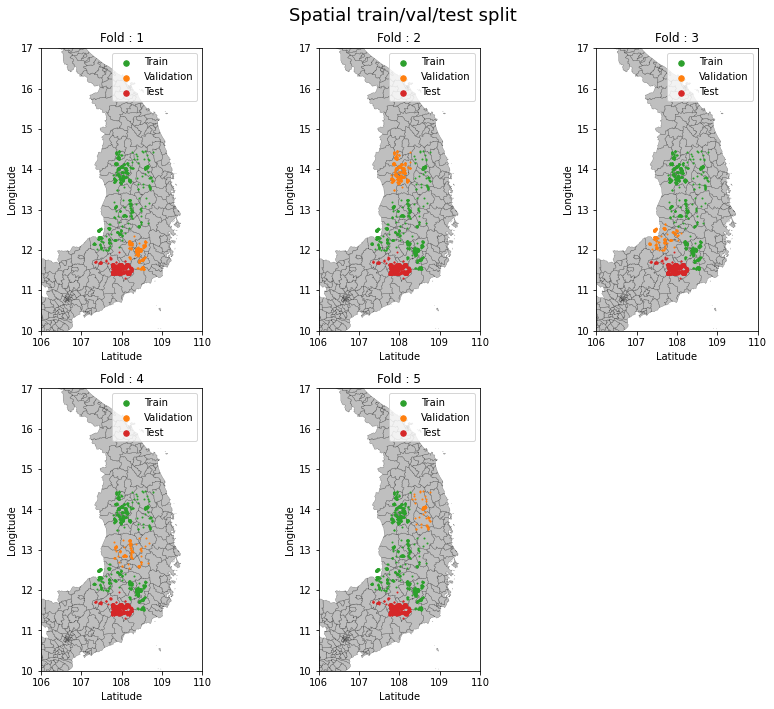

In [30]:
skcv = spacv.SKCV(n_splits=5, buffer_radius=0.1).split(data_train['geometry'])
fig, axes = plt.subplots(figsize=(12,10), nrows=2, ncols=3)

axes = axes.flatten()

i = 0

for train, validation in skcv:
    ax = axes[i]
    geo_train = data_train.iloc[train]
    geo_val = data_train.iloc[validation]
    
    print(f"Fold {i+1} Number coffee - train : {len(geo_train[geo_train['label'] == 2])}")
    print(f"Fold {i+1} Number no-coffee - train : {len(geo_train[geo_train['label'] != 2])}")

    print(f"Fold {i+1} Number coffee - val : {len(geo_val[geo_val['label'] == 2])}")
    print(f"Fold {i+1} Number no-coffee - val : {len(geo_val[geo_val['label'] != 2])}")
    print("-----")
    
    vietnam.plot(ax=ax,facecolor='Grey', edgecolor='k',alpha=0.5,linewidth=0.3)

    
    geo_train.plot(ax=ax, markersize=1,categorical=True, legend=True, c="tab:green")
    geo_val.plot(ax=ax, markersize=1,categorical=True, legend=True, c="tab:orange")
    data_test.plot(ax=ax,markersize=1,categorical=True, legend=True, c="tab:red")

    ax.set_ylim([10,17])
    ax.set_xlim([106,110])
    ax.set_xlabel("Latitude")
    ax.set_ylabel("Longitude")
    ax.set_title(f"Fold : {i+1}")
    fig.suptitle("Spatial train/val/test split", fontsize=18)
    legend = ax.legend(["Train", "Validation", "Test"])
    legend.legendHandles[0]._sizes = [30]
    legend.legendHandles[1]._sizes = [30]
    legend.legendHandles[2]._sizes = [30]

    fig.tight_layout()
    i+=1
    
fig.delaxes(ax= axes[-1]) 
print(f"Number coffee - test : {len(data_test[data_test['label'] == 2])}")
print(f"Number no-coffee - test : {len(data_test[data_test['label'] != 2])}")
print("-----")

## Discussion
This example allows us to see that the number of coffee fields from one fold to another can be very different. Moreover, the separation between the training and the test set is very strict.

# Dataset Split  - 10 Fold version
For culture vs no-culture use the same algotithm but replace :
```python
all_data.loc[all_data['label'] != 2, 'label_coffee'] = 1
all_data.loc[all_data['label'] == 2, 'label_coffee'] = 0
```
by : 
```python
all_data.loc[all_data['label'].isin(culture_list), 'label_culture'] = 0
all_data.loc[all_data['label'].isin(no_culture_list), 'label_culture'] =1
```

and change export file name. For 32x32 images changes : 
```python
all_data = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'strat_all.csv')))
```
by : 
```python
all_data = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'strat_all_32.csv')))
```

## Train / test split
### Load the data

In [3]:
all_data = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'strat_all_32.csv')))
all_data['geometry'] = all_data['geometry'].apply(wkt.loads)

all_data.loc[all_data['label'] != 2, 'label'] = 1
all_data.loc[all_data['label'] == 2, 'label'] = 0

coffee_data = all_data[all_data['label'] == 0].reset_index(drop=True)
other_data = all_data[all_data['label'] == 1].reset_index(drop=True)

### Run algorithm on 10 folds
The spacv algorithm is executed for 10 folds on the two different .

In [4]:
NB_FOLD = 10
skcv_coffee = spacv.SKCV(n_splits=NB_FOLD, buffer_radius=0.1).split(coffee_data['geometry'])
skcv_other = spacv.SKCV(n_splits=NB_FOLD, buffer_radius=0.1).split(other_data['geometry'])
list_fold = []
i = 0

for coffee, other in zip(skcv_coffee, skcv_other):  
    list_fold.append({"train_coffee":coffee[0], "train_other":other[0], "val_coffee":coffee[1], "val_other":other[1]})
    i+=1

### Shuffle the folds

In [5]:
list_fold = np.array(list_fold)
np.random.shuffle(list_fold)

### Join the folds
The 10 folds for each class are browsed 2 by 2. 2 folds for class 0 and 2 folds for class 1 are kept for validation. The 8 folds of class 0 and the 8 folds of class 1 are kept for training.

Fold 1 Number coffee - train : 806
Fold 1 Number no-coffee - train : 2200
Fold 1 Number coffee - val : 243
Fold 1 Number no-coffee - val : 654
0.7701767870868562
0.22982321291314373
-----
Fold 2 Number coffee - train : 924
Fold 2 Number no-coffee - train : 2119
Fold 2 Number coffee - val : 125
Fold 2 Number no-coffee - val : 735
0.7796566743530617
0.22034332564693826
-----
Fold 3 Number coffee - train : 827
Fold 3 Number no-coffee - train : 2275
Fold 3 Number coffee - val : 222
Fold 3 Number no-coffee - val : 579
0.7947732513451191
0.20522674865488086
-----
Fold 4 Number coffee - train : 863
Fold 4 Number no-coffee - train : 2508
Fold 4 Number coffee - val : 186
Fold 4 Number no-coffee - val : 346
0.8636945939021266
0.13630540609787342
-----
Fold 5 Number coffee - train : 776
Fold 5 Number no-coffee - train : 2314
Fold 5 Number coffee - val : 273
Fold 5 Number no-coffee - val : 540
0.7916986933128363
0.2083013066871637
-----


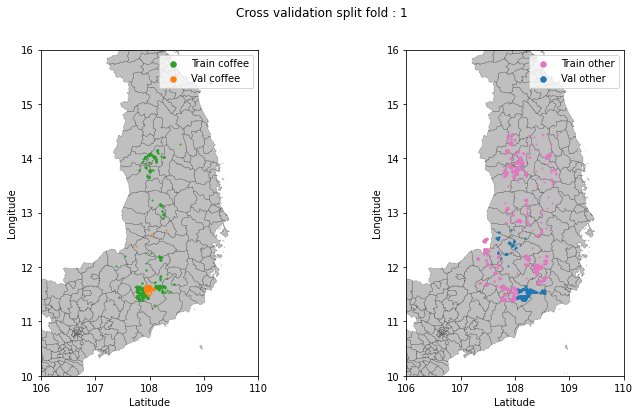

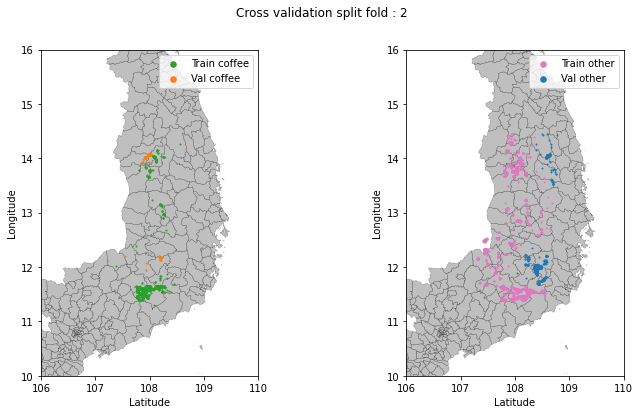

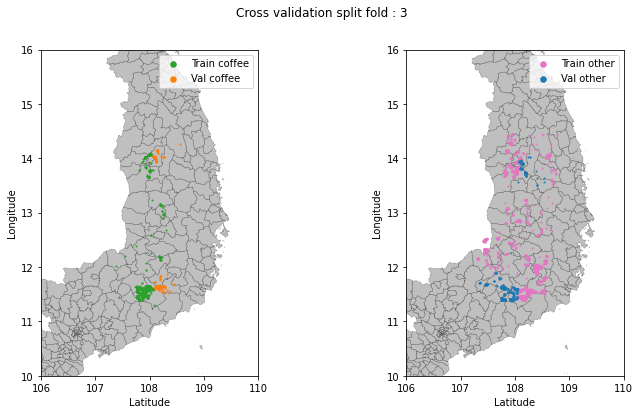

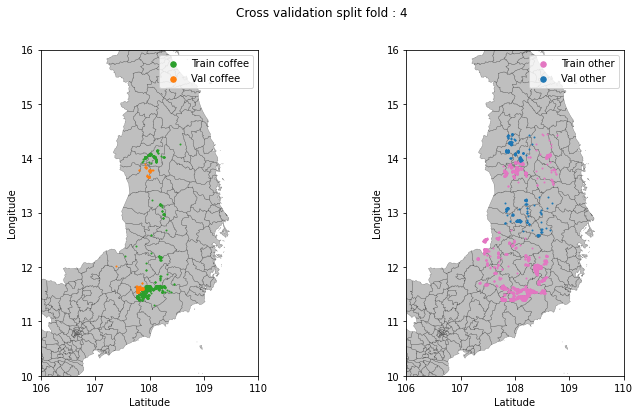

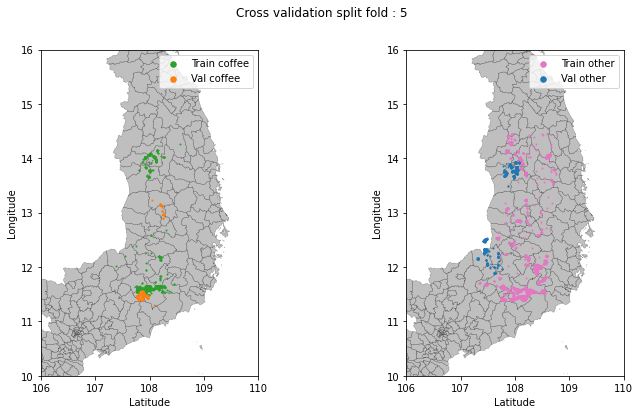

In [6]:
saved_folds = []

for i_fold in range(0, len(list_fold), 2):
    current_indexs = [i_fold, i_fold+1]
    other_indexs = list(set(range(0,10)) - set(current_indexs))
    
    val_coffee = []
    val_other = []
    for l in list_fold[current_indexs]:
        val_coffee.extend(l['val_coffee'])
        val_other.extend(l['val_other'])
        
    train_coffee = []
    train_other = []
    for l in list_fold[other_indexs]:
        train_coffee.extend(l['val_coffee'])
        train_other.extend(l['val_other'])
    
    geo_train = coffee_data.iloc[train_coffee].append(other_data.iloc[train_other], ignore_index=True)
    geo_val = coffee_data.iloc[val_coffee].append(other_data.iloc[val_other], ignore_index=True)
    
    saved_folds.append({'geo_train':geo_train, 'geo_val':geo_val})
    
    index = (i_fold//2)+1
    display_cross_val_map_class(geo_train, geo_val, vietnam, f"Cross validation split fold : {index}")


    print(f"Fold {index} Number coffee - train : {len(geo_train[geo_train['label'] == 0])}")
    print(f"Fold {index} Number no-coffee - train : {len(geo_train[geo_train['label'] == 1])}")

    print(f"Fold {index} Number coffee - val : {len(geo_val[geo_val['label'] == 0 ])}")
    print(f"Fold {index} Number no-coffee - val : {len(geo_val[geo_val['label'] == 1])}")
    
    print(len(geo_train)/(len(geo_train)+len(geo_val)))
    print(len(geo_val)/(len(geo_train)+len(geo_val)))
    print("-----")

### Save data on disk

In [37]:
saved_folds[0]['geo_train'].to_csv(os.path.join('datasets','coffee_10fold_32', 'train_data_32.csv'), index=False)
saved_folds[0]['geo_val'].to_csv(os.path.join('datasets','coffee_10fold_32', 'test_data_32.csv'), index=False)

### Reload data

In [6]:
data_train = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets','coffee_10fold_32', 'train_data_32.csv')))
data_train['geometry'] = data_train['geometry'].apply(wkt.loads)

data_test = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets','coffee_10fold_32', 'test_data_32.csv')))
data_test['geometry'] = data_test['geometry'].apply(wkt.loads)

### Verifications
Check that there are no duplicate images in train set and the test set

In [124]:
set_tr = set(data_train['path'].to_numpy())
set_te = set(data_test['path'].to_numpy())
print(f"{len(set_tr.intersection(set_te))} images of the training set in test set and vice versa")

0 images of the training set in test set and vice versa


## Split Train / validation
The same algorithm is run again on the training set for the training/validation separation.

In [8]:
coffee_data = data_train[data_train['label'] == 0].reset_index(drop=True)
other_data = data_train[data_train['label'] == 1].reset_index(drop=True)

### Run algorithm on 10 folds
The spacv algorithm is executed for 10 folds on the two different classes

In [9]:
NB_FOLD = 10
skcv_coffee = spacv.SKCV(n_splits=NB_FOLD, buffer_radius=0.1).split(coffee_data['geometry'])
skcv_other = spacv.SKCV(n_splits=NB_FOLD, buffer_radius=0.1).split(other_data['geometry'])
list_fold = []
i = 0

for coffee, other in zip(skcv_coffee, skcv_other):  
    list_fold.append({"train_coffee":coffee[0], "train_other":other[0], "val_coffee":coffee[1], "val_other":other[1]})
    i+=1
    
list_fold = np.array(list_fold)
np.random.shuffle(list_fold)

### Join the folds
The 10 folds for each class are browsed 2 by 2. 2 folds for class 0 and 2 folds for class 1 are kept for validation. The 8 folds of class 0 and the 8 folds of class 1 are kept for training.

Fold 1 Number coffee - train : 826
Fold 1 Number no-coffee - train : 1410
Fold 1 Number coffee - val : 116
Fold 1 Number no-coffee - val : 714
0.7292889758643183
0.27071102413568165
-----
Fold 2 Number coffee - train : 710
Fold 2 Number no-coffee - train : 1956
Fold 2 Number coffee - val : 232
Fold 2 Number no-coffee - val : 168
0.8695368558382257
0.1304631441617743
-----
Fold 3 Number coffee - train : 716
Fold 3 Number no-coffee - train : 1797
Fold 3 Number coffee - val : 226
Fold 3 Number no-coffee - val : 327
0.819634703196347
0.18036529680365296
-----
Fold 4 Number coffee - train : 680
Fold 4 Number no-coffee - train : 1517
Fold 4 Number coffee - val : 262
Fold 4 Number no-coffee - val : 607
0.7165688193085453
0.2834311806914547
-----
Fold 5 Number coffee - train : 836
Fold 5 Number no-coffee - train : 1816
Fold 5 Number coffee - val : 106
Fold 5 Number no-coffee - val : 308
0.8649706457925636
0.1350293542074364
-----


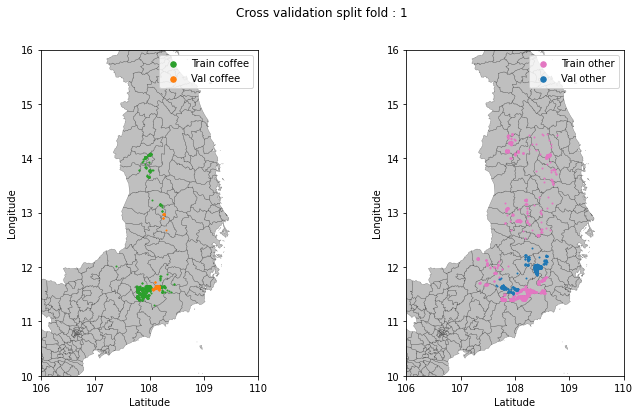

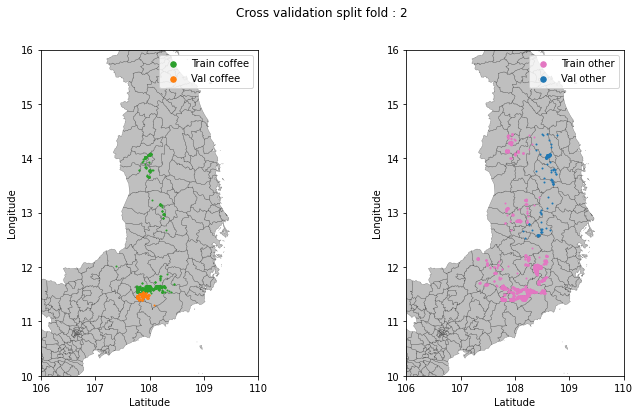

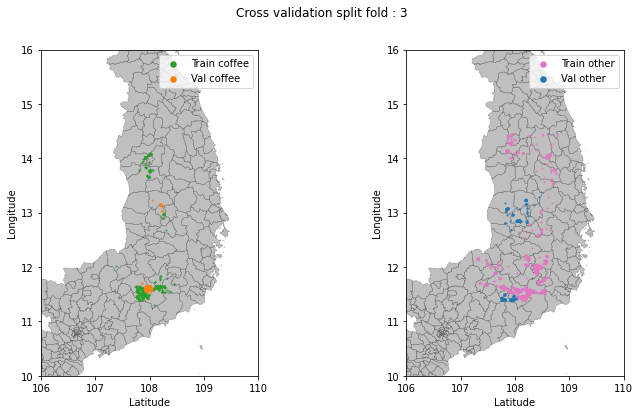

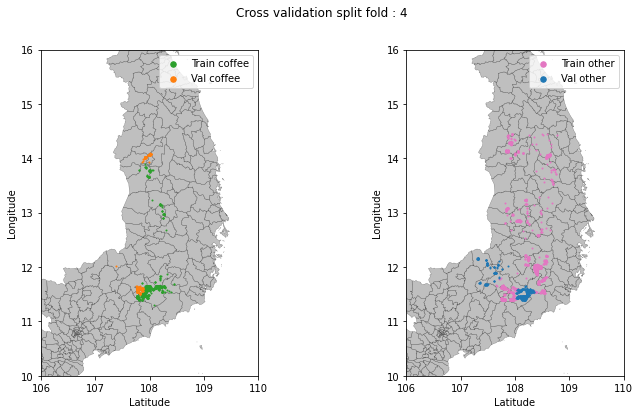

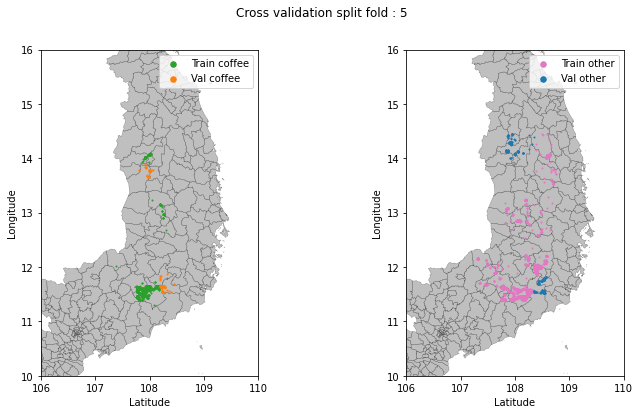

In [10]:
for i_fold in range(0, len(list_fold), 2):
    current_indexs = [i_fold, i_fold+1]
    other_indexs = list(set(range(0,10)) - set(current_indexs))
    
    val_coffee = []
    val_other = []
    for l in list_fold[current_indexs]:
        val_coffee.extend(l['val_coffee'])
        val_other.extend(l['val_other'])
        
    train_coffee = []
    train_other = []
    for l in list_fold[other_indexs]:
        train_coffee.extend(l['val_coffee'])
        train_other.extend(l['val_other'])
    
    geo_train = coffee_data.iloc[train_coffee].append(other_data.iloc[train_other], ignore_index=True)
    geo_val = coffee_data.iloc[val_coffee].append(other_data.iloc[val_other], ignore_index=True)
        
    index = (i_fold//2)+1
    display_cross_val_map_class(geo_train, geo_val, vietnam, f"Cross validation split fold : {index}")


    print(f"Fold {index} Number coffee - train : {len(geo_train[geo_train['label'] == 0])}")
    print(f"Fold {index} Number no-coffee - train : {len(geo_train[geo_train['label'] == 1])}")

    print(f"Fold {index} Number coffee - val : {len(geo_val[geo_val['label'] == 0 ])}")
    print(f"Fold {index} Number no-coffee - val : {len(geo_val[geo_val['label'] == 1])}")
    
    print(len(geo_train)/(len(geo_train)+len(geo_val)))
    print(len(geo_val)/(len(geo_train)+len(geo_val)))
    
    geo_train.to_csv(os.path.join("datasets", "coffee_10fold_32", f"train_{index}_data_32.csv"), index=False)
    geo_val.to_csv(os.path.join("datasets", "coffee_10fold_32", f"val_{index}_data_32.csv"), index=False)
    print("-----")

### Verifications
Check that there are no duplicate images in any of the folds and the test set

In [ ]:
train_fold1 =  gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets','coffee_10fold_32', f'train_{1}_data_32.csv')))
val_fold1 = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets','coffee_10fold_32', f'val_{1}_data._32csv')))

set_tr = set(train_fold1['path'].to_numpy())
set_val = set(val_fold1['path'].to_numpy())
print(f"{len(set_tr.intersection(set_val))} images of the training set in validation set and vice versa")

set_tr = set_tr.union(set_val)
set_te = set(data_test['path'].to_numpy())
print(f"{len(set_tr.intersection(set_te))} images of the training set in validation set and vice versa")

# Multilabel datasets split - 10 Fold version
## Train / test split
Load data and set label for culture and no-culture. For this version the split is based on culture vs non-culture

In [3]:
all_data = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'strat_all.csv')))
all_data['geometry'] = all_data['geometry'].apply(wkt.loads)

culture_list = [1,2,6,15,18,19,17] #  6 caoutchou, 25 poivre de cayenne, 16 cassava, 23 intercrop
no_culture_list = [4,9,10, 24,27] # 11 other tree, 27 pines tree
all_data = all_data[all_data['label'].isin(culture_list + no_culture_list)]

all_data.loc[all_data['label'].isin(culture_list), 'label_culture'] = 0
all_data.loc[all_data['label'].isin(no_culture_list), 'label_culture'] =1

all_data.loc[all_data['label'] != 2, 'label_coffee'] = 1
all_data.loc[all_data['label'] == 2, 'label_coffee'] = 0

all_data[['label_culture', 'label_coffee']] = all_data[['label_culture', 'label_coffee']].astype(int)

culture_data = all_data[all_data['label_culture'] == 0].reset_index(drop=True)
no_culture_data = all_data[all_data['label_culture'] == 1].reset_index(drop=True)

### Run algorithm on 10 folds
The spacv algorithm is executed for 10 folds on the two different .

In [7]:
NB_FOLD = 10
skcv_culture = spacv.SKCV(n_splits=NB_FOLD, buffer_radius=0.1).split(culture_data['geometry'])
skcv_no_culture = spacv.SKCV(n_splits=NB_FOLD, buffer_radius=0.1).split(no_culture_data['geometry'])
list_fold = []
i = 0

for culture, no_culture in zip(skcv_culture, skcv_no_culture):  
    list_fold.append({"train_culture":culture[0], "train_no_culture":no_culture[0], "val_culture":culture[1], "val_no_culture":no_culture[1]})

### Shuffle the folds

In [13]:
list_fold = np.array(list_fold)
np.random.shuffle(list_fold)

### Join the folds
The 10 folds for each class are browsed 2 by 2. 2 folds for class 0 and 2 folds for class 1 are kept for validation. The 8 folds of class 0 and the 8 folds of class 1 are kept for training.

Fold 1 Number culture - train : 862
Fold 1 Number no-culture - train : 645
Fold 1 Number coffee - train : 427
Fold 1 Number other - train : 1080
Fold 1 Number culture - val : 130
Fold 1 Number no-culture - val : 237
Fold 1 Number coffee - train : 71
Fold 1 Number other - train : 296
0.804162219850587
0.19583778014941303
-----
Fold 2 Number culture - train : 818
Fold 2 Number no-culture - train : 738
Fold 2 Number coffee - train : 478
Fold 2 Number other - train : 1078
Fold 2 Number culture - val : 174
Fold 2 Number no-culture - val : 144
Fold 2 Number coffee - train : 20
Fold 2 Number other - train : 298
0.8303094983991463
0.16969050160085378
-----
Fold 3 Number culture - train : 822
Fold 3 Number no-culture - train : 758
Fold 3 Number coffee - train : 399
Fold 3 Number other - train : 1181
Fold 3 Number culture - val : 170
Fold 3 Number no-culture - val : 124
Fold 3 Number coffee - train : 99
Fold 3 Number other - train : 195
0.8431163287086446
0.1568836712913554
-----
Fold 4 Number c

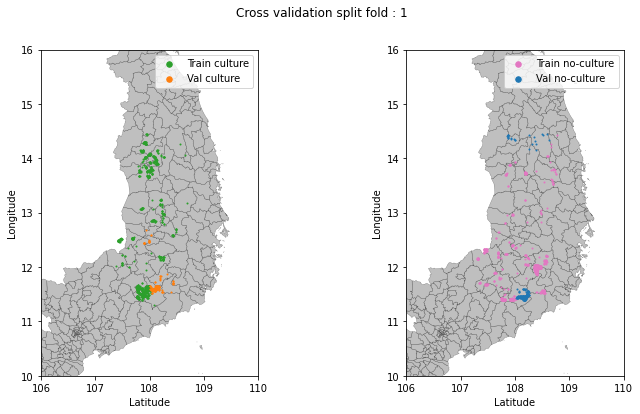

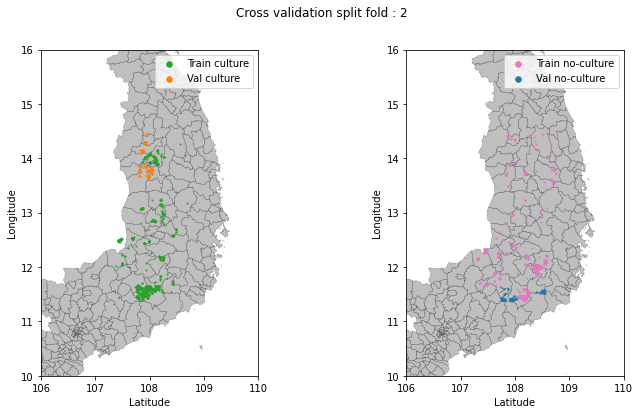

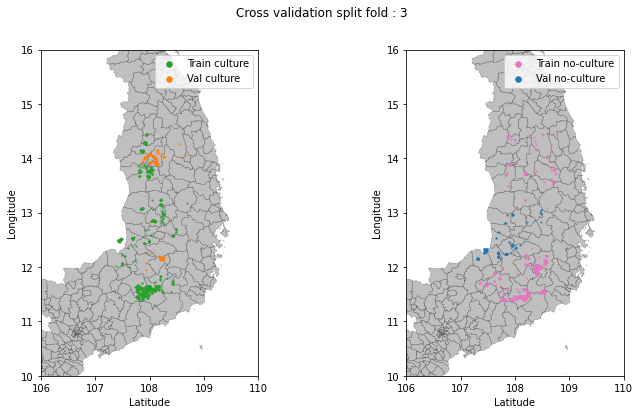

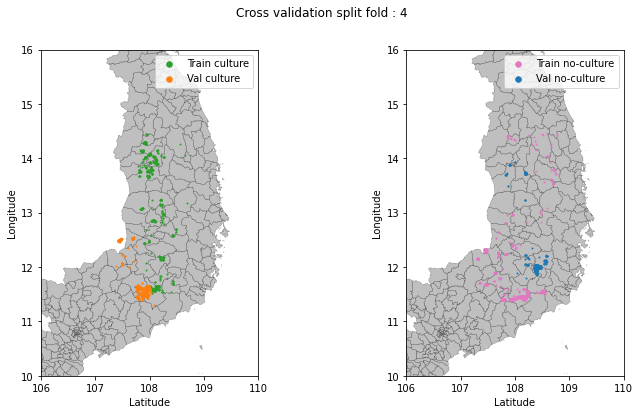

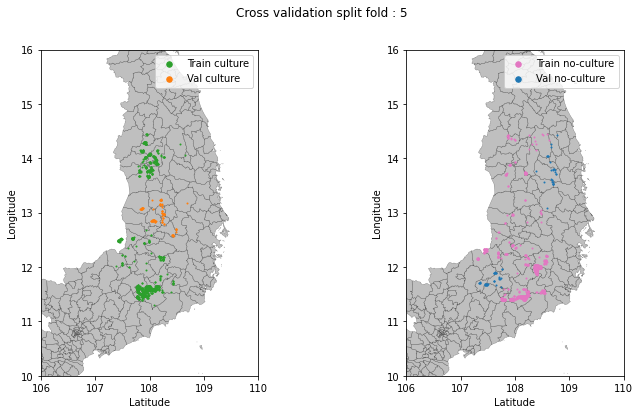

In [14]:
saved_folds = []

for i_fold in range(0, len(list_fold), 2):
    current_indexs = [i_fold, i_fold+1]
    other_indexs = list(set(range(0,10)) - set(current_indexs))
    
    val_culture = []
    val_no_culture = []
    for l in list_fold[current_indexs]:
        val_culture.extend(l['val_culture'])
        val_no_culture.extend(l['val_no_culture'])
        
    train_culture = []
    train_no_culture = []
    for l in list_fold[other_indexs]:
        train_culture.extend(l['val_culture'])
        train_no_culture.extend(l['val_no_culture'])
    
    geo_train = culture_data.iloc[train_culture].append(no_culture_data.iloc[train_no_culture], ignore_index=True)
    geo_val = culture_data.iloc[val_culture].append(no_culture_data.iloc[val_no_culture], ignore_index=True)
    
    saved_folds.append({'geo_train':geo_train, 'geo_val':geo_val})
    
    index = (i_fold//2)+1
    display_cross_val_map_class(geo_train, geo_val, vietnam, f"Cross validation split fold : {index}", column_name='label_culture',legend1=['Train culture', 'Val culture'], legend2=['Train no-culture', 'Val no-culture'])

    print(f"Fold {index} Number culture - train : {len(geo_train[geo_train['label_culture'] == 0])}")
    print(f"Fold {index} Number no-culture - train : {len(geo_train[geo_train['label_culture'] == 1])}")
    print(f"Fold {index} Number coffee - train : {len(geo_train[geo_train['label_coffee'] == 0])}")
    print(f"Fold {index} Number other - train : {len(geo_train[geo_train['label_coffee'] == 1])}")

    print(f"Fold {index} Number culture - val : {len(geo_val[geo_val['label_culture'] == 0 ])}")
    print(f"Fold {index} Number no-culture - val : {len(geo_val[geo_val['label_culture'] == 1])}")
    print(f"Fold {index} Number coffee - train : {len(geo_val[geo_val['label_coffee'] == 0])}")
    print(f"Fold {index} Number other - train : {len(geo_val[geo_val['label_coffee'] == 1])}")
    
    print(len(geo_train)/(len(geo_train)+len(geo_val)))
    print(len(geo_val)/(len(geo_train)+len(geo_val)))
    print("-----")

### Save data on disk

In [27]:
saved_folds[2]['geo_train'].to_csv(os.path.join('datasets', 'culture_coffee_10fold','train_data.csv'), index=False)
saved_folds[2]['geo_val'].to_csv(os.path.join('datasets', 'culture_coffee_10fold','test_data.csv'), index=False)

### Reload data

In [28]:
data_train = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets','culture_coffee_10fold', 'train_data.csv')))
data_train['geometry'] = data_train['geometry'].apply(wkt.loads)

data_test = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets','culture_coffee_10fold', 'test_data.csv')))
data_test['geometry'] = data_test['geometry'].apply(wkt.loads)

### Verifications
Check that there are no duplicate images in train set and the test set

In [29]:
set_tr = set(data_train['path'].to_numpy())
set_te = set(data_test['path'].to_numpy())
print(f"{len(set_tr.intersection(set_te))} images of the training set in test set and vice versa")

0 images of the training set in test set and vice versa


## Split Train / validation
The same algorithm is run again on the training set for the training/validation separation.

In [43]:
culture_data = data_train[data_train['label_culture'] == 0].reset_index(drop=True)
no_culture_data = data_train[data_train['label_culture'] == 1].reset_index(drop=True)

### Run algorithm on 10 folds
The spacv algorithm is executed for 10 folds on the two different classes

In [44]:
NB_FOLD = 10
skcv_culture = spacv.SKCV(n_splits=NB_FOLD, buffer_radius=0.1).split(culture_data['geometry'])
skcv_no_culture = spacv.SKCV(n_splits=NB_FOLD, buffer_radius=0.1).split(no_culture_data['geometry'])
list_fold = []
i = 0

for culture, no_culture in zip(skcv_culture, skcv_no_culture):  
    list_fold.append({"train_culture":culture[0], "train_no_culture":no_culture[0], "val_culture":culture[1], "val_no_culture":no_culture[1]})
    
list_fold = np.array(list_fold)
np.random.shuffle(list_fold)

### Join the folds
The 10 folds for each class are browsed 2 by 2. 2 folds for class 0 and 2 folds for class 1 are kept for validation. The 8 folds of class 0 and the 8 folds of class 1 are kept for training.

Fold 1 Number culture - train : 738
Fold 1 Number no-culture - train : 613
Fold 1 Number coffee - train : 405
Fold 1 Number other - train : 946
Fold 1 Number culture - val : 98
Fold 1 Number no-culture - val : 141
Fold 1 Number coffee - train : 20
Fold 1 Number other - train : 219
0.849685534591195
0.15031446540880503
-----
Fold 2 Number culture - train : 610
Fold 2 Number no-culture - train : 717
Fold 2 Number coffee - train : 305
Fold 2 Number other - train : 1022
Fold 2 Number culture - val : 226
Fold 2 Number no-culture - val : 37
Fold 2 Number coffee - train : 120
Fold 2 Number other - train : 143
0.8345911949685535
0.16540880503144653
-----
Fold 3 Number culture - train : 674
Fold 3 Number no-culture - train : 702
Fold 3 Number coffee - train : 380
Fold 3 Number other - train : 996
Fold 3 Number culture - val : 162
Fold 3 Number no-culture - val : 52
Fold 3 Number coffee - train : 45
Fold 3 Number other - train : 169
0.8654088050314466
0.13459119496855346
-----
Fold 4 Number cult

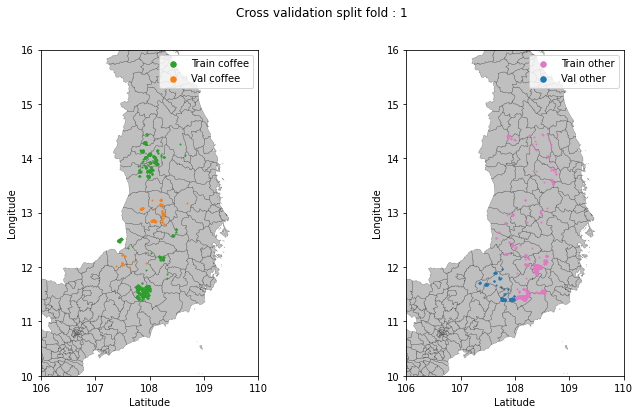

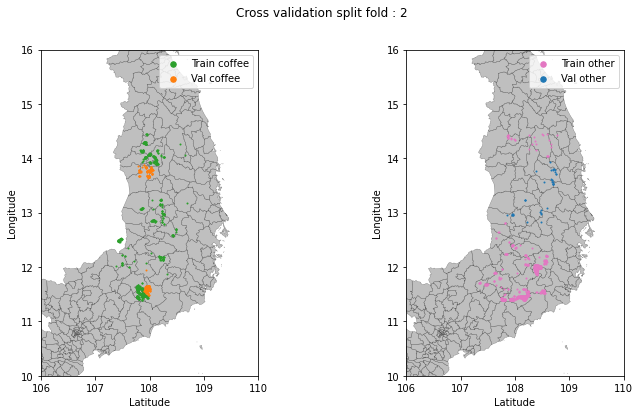

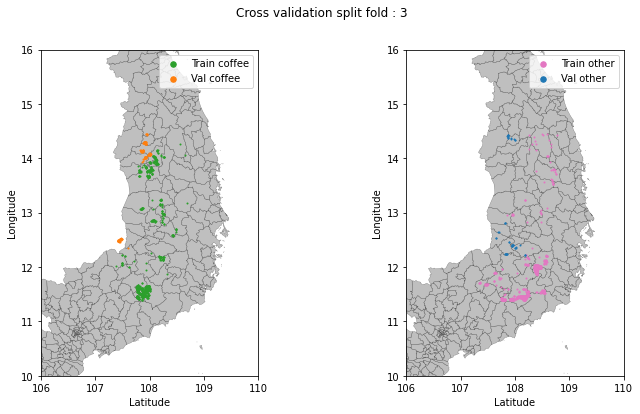

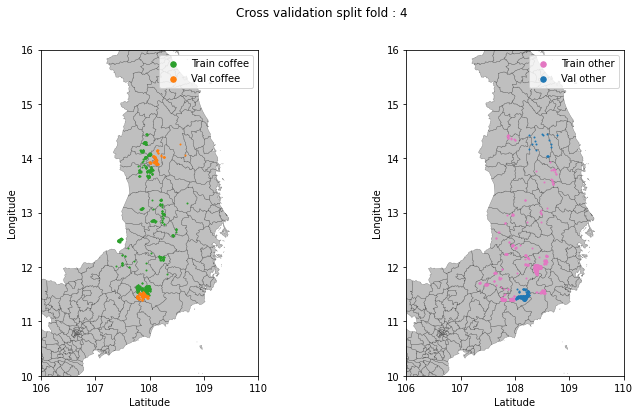

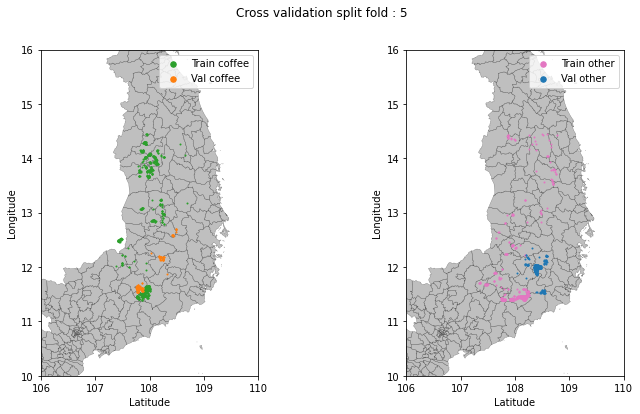

In [45]:
for i_fold in range(0, len(list_fold), 2):
    current_indexs = [i_fold, i_fold+1]
    other_indexs = list(set(range(0,10)) - set(current_indexs))
    
    val_culture = []
    val_no_culture = []
    for l in list_fold[current_indexs]:
        val_culture.extend(l['val_culture'])
        val_no_culture.extend(l['val_no_culture'])
        
    train_culture = []
    train_no_culture = []
    for l in list_fold[other_indexs]:
        train_culture.extend(l['val_culture'])
        train_no_culture.extend(l['val_no_culture'])
    
    geo_train = culture_data.iloc[train_culture].append(no_culture_data.iloc[train_no_culture], ignore_index=True)
    geo_val = culture_data.iloc[val_culture].append(no_culture_data.iloc[val_no_culture], ignore_index=True)
    
    
    index = (i_fold//2)+1
    display_cross_val_map_class(geo_train, geo_val, vietnam, f"Cross validation split fold : {index}",column_name='label_culture',legend1=['Train culture', 'Val culture'], legend2=['Train no-culture', 'Val no-culture'])

    print(f"Fold {index} Number culture - train : {len(geo_train[geo_train['label_culture'] == 0])}")
    print(f"Fold {index} Number no-culture - train : {len(geo_train[geo_train['label_culture'] == 1])}")
    print(f"Fold {index} Number coffee - train : {len(geo_train[geo_train['label_coffee'] == 0])}")
    print(f"Fold {index} Number other - train : {len(geo_train[geo_train['label_coffee'] == 1])}")

    print(f"Fold {index} Number culture - val : {len(geo_val[geo_val['label_culture'] == 0 ])}")
    print(f"Fold {index} Number no-culture - val : {len(geo_val[geo_val['label_culture'] == 1])}")
    print(f"Fold {index} Number coffee - train : {len(geo_val[geo_val['label_coffee'] == 0])}")
    print(f"Fold {index} Number other - train : {len(geo_val[geo_val['label_coffee'] == 1])}")
    
    print(len(geo_train)/(len(geo_train)+len(geo_val)))
    print(len(geo_val)/(len(geo_train)+len(geo_val)))
    
    geo_train.to_csv(os.path.join("datasets", "culture_coffee_10fold", f"train_{index}_data.csv"), index=False)
    geo_val.to_csv(os.path.join("datasets", "culture_coffee_10fold", f"val_{index}_data.csv"), index=False)
    print("-----")

### Verifications
Check that there are no duplicate images in any of the folds and the test set

In [46]:
train_fold1 =  gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets','culture_coffee_10fold', f'train_{1}_data.csv')))
val_fold1 = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets','culture_coffee_10fold', f'val_{1}_data.csv')))

set_tr = set(train_fold1['path'].to_numpy())
set_val = set(val_fold1['path'].to_numpy())
print(f"{len(set_tr.intersection(set_val))} images of the training set in validation set and vice versa")

set_tr = set_tr.union(set_val)
set_te = set(data_test['path'].to_numpy())
print(f"{len(set_tr.intersection(set_te))} images of the training set in validation set and vice versa")

0 images of the training set in validation set and vice versa
0 images of the training set in validation set and vice versa
